In [189]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from argparse import Namespace
import re

In [131]:
args = Namespace(
    calibratedFile = "cleanData.csv",
    targetColumn = 'conversion_roi',
    numericalColumns = ['exchange_viewability_rate_log', 'exchange_ctr','recencyLog', 'frequency'],
    categorical = [  'qualifiedPixel',
                     'browser_version_device_model',
                     'hashed_app_id_device_model',
                     'deal_id',
                     'category_id',
                     'dma_id',
                     'browser_language_id',
                     'region_id',
                     'exchange_id',
                     'isp_id',
                     'impression_date',
                     'size',
                     'day_of_week',
                     'creative_id',
                     'id_vintage',
                     'device_id',
                     'day_part',
                     'conn_speed',
                     'fold_position',
                     'channel_type',
                     'num_device_ids',
                     'country_id',
                     'cross_device_flag',
                     'base_domain_device_model',
                     'site_id_device_model',
                     'publisher_id_device_model' ],
    toBeProcessed =["device_model", "os_version","browser_version","device_type"],
    categoricalNew = [],
    mapDict = {},
)    

In [198]:
re.search("Boott",model[-1].__class__.__name__,re.IGNORECASE),model[-1].__class__.__name__

(None, 'HistGradientBoostingRegressor')

In [132]:
dfRaw = pd.read_csv(args.calibratedFile)

### Preprocessing the data

In [133]:
for colName in args.toBeProcessed:
    validValues = list(dfRaw[dfRaw.apply(lambda x: not pd.isna(x[colName]), axis=1)][colName].unique())
    args.mapDict[colName] = dict([[name,i+1] for i,name in enumerate(validValues)])
    dfRaw["{} Code".format(colName)] = dfRaw.apply(lambda x: 0 if pd.isna(x[colName]) else args.mapDict[colName][x[colName]], axis=1)
    args.categoricalNew = args.categoricalNew + ["{} Code".format(colName)]

In [139]:
df=dfRaw[args.categorical+args.categoricalNew+[args.targetColumn]+args.numericalColumns+["Date"]]

In [140]:
df.head()

,qualifiedPixel,browser_version_device_model,hashed_app_id_device_model,deal_id,category_id,dma_id,browser_language_id,region_id,exchange_id,isp_id,...,device_model Code,os_version Code,browser_version Code,device_type Code,conversion_roi,exchange_viewability_rate_log,exchange_ctr,recencyLog,frequency,Date
0,False,0,239,452881,42,80003,0,70034,2100,30031,...,1,1,0,1,0.0,0.000000,0.0,10.362880,2.561426,2022-11-22
1,False,85,28,0,432963713,80029,28261,70016,3,30014,...,1,1,1,1,0.0,0.000000,0.0,10.362880,2.561426,2022-11-22
2,False,85,28,0,1466174921,80000,0,74137,221,30000,...,1,1,1,1,0.0,4.189655,0.0,10.362880,2.561426,2022-11-22
3,True,85,28,0,2129642030,80029,28261,70016,3,30081,...,1,2,1,1,0.0,0.000000,0.0,9.081029,1.000000,2022-11-22
4,True,22,25,0,1179272140,80000,0,74137,221,30000,...,2,3,2,2,0.0,4.189655,0.0,11.105754,1.000000,2022-11-22


In [141]:
df.loc[1]

qualifiedPixel                        False
browser_version_device_model             85
hashed_app_id_device_model               28
deal_id                                   0
category_id                       432963713
dma_id                                80029
browser_language_id                   28261
region_id                             70016
exchange_id                               3
isp_id                                30014
impression_date                  2022-11-22
size                               20971570
day_of_week                               2
creative_id                        11140116
id_vintage                                1
device_id                             41000
day_part                                  1
conn_speed                            20005
fold_position                             0
channel_type                              4
num_device_ids                            1
country_id                            60231
cross_device_flag               

In [142]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough", args.numericalColumns),
        (
            "onehot_categorical",
            OneHotEncoder(),
            args.categorical+args.categoricalNew,
        ),
    ],
    remainder="drop",
)

In [151]:
df_train = df[df.apply(lambda x: x["Date"] not in ['2022-12-05','2022-12-04'], axis=1)].copy(deep=True)
df_test = df[df.apply(lambda x: x["Date"] in ['2022-12-05','2022-12-04'], axis=1)].copy(deep=True)
df_test["rowCount"] = [_ for _ in range(df_test.shape[0])]
for name in args.categorical+args.categoricalNew:
    values = list(df_train[name].unique())
    selectValues = np.random.randint(len(values), size=df_test.shape[0])
    df_test[name] = df_test.apply(lambda x: x[name] if x[name] in values else values[selectValues[x["rowCount"]]], axis=1)

In [152]:
df_test.shape[0]/(df_test.shape[0]+df_train.shape[0]),df_test.shape[0]+df_train.shape[0]

(0.10758484939205792, 1382862)

In [218]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline

zero = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", DummyRegressor(strategy="constant", constant=1e-10)), #strict 0 is not allowed in deviance calculation
    ]
).fit(df_train, df_train[args.targetColumn])

dummy = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", DummyRegressor(strategy="mean")),
    ]
).fit(df_train, df_train[args.targetColumn])

In [220]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance


def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test)
    y_predUsed = y_pred
    y_predUsed[y_predUsed<0]=0
    print( "RMSE:{:.3f}".format( np.sqrt(mean_squared_error( df_test[args.targetColumn], y_predUsed ))))
    print( "RMAE:{:.3f}".format( np.sqrt(mean_absolute_error( df_test[args.targetColumn], y_predUsed ))))

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print( "WARNING: Estimator yields invalid, non-positive predictions  \
            for {} samples out of {}. These predictions \
            are ignored when computing the Poisson deviance.".format(n_masked,n_samples) )

    print( "mean Poisson deviance: {:.3f}".format(mean_poisson_deviance( df_test[args.targetColumn][mask], y_pred[mask]))) 

In [221]:
print("Zero mean frequency evaluation Test:")
score_estimator(zero, df_test)
print("Zero mean frequency evaluation Train:")
score_estimator(zero, df_train)
print("Constant mean frequency evaluation Test:")
score_estimator(dummy, df_test)
print("Constant mean frequency evaluation Train:")
score_estimator(dummy, df_train)

Zero mean frequency evaluation Test:
RMSE:0.158
RMAE:0.142
mean Poisson deviance: 0.889
Zero mean frequency evaluation Train:
RMSE:0.172
RMAE:0.150
mean Poisson deviance: 0.985
Constant mean frequency evaluation Test:
RMSE:0.157
RMAE:0.203
mean Poisson deviance: 0.154
Constant mean frequency evaluation Train:
RMSE:0.170
RMAE:0.208
mean Poisson deviance: 0.167


In [222]:
from sklearn.linear_model import Ridge
ridge_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", Ridge(alpha=1e-4)),
    ]
).fit(df_train, df_train[args.targetColumn])

In [223]:
print("Ridge evaluation Test:")
score_estimator(ridge_glm, df_test)
print("Ridge evaluation Training:")
score_estimator(ridge_glm, df_train)

Ridge evaluation Test:
RMSE:0.157
RMAE:0.212
mean Poisson deviance: 0.161
Ridge evaluation Training:
RMSE:0.167
RMAE:0.205
mean Poisson deviance: 0.168


In [224]:
from sklearn.linear_model import PoissonRegressor

n_samples = df_train.shape[0]

poisson_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", PoissonRegressor(alpha=1e-4, solver="newton-cholesky")),
    ]
)
poisson_glm.fit(df_train, df_train[args.targetColumn])

print("PoissonRegressor evaluation Test:")
score_estimator(poisson_glm, df_test)
print("PoissonRegressor evaluation Train:")
score_estimator(poisson_glm, df_train)

PoissonRegressor evaluation Test:
RMSE:0.156
RMAE:0.205
mean Poisson deviance: 0.141
PoissonRegressor evaluation Train:
RMSE:0.168
RMAE:0.202
mean Poisson deviance: 0.146


In [203]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder


tree_preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            OrdinalEncoder(),
            args.categorical+args.categoricalNew,
        ),
        ("numeric", "passthrough", args.numericalColumns),
    ],
    remainder="drop",
)
poisson_gbrt = Pipeline(
    [
        ("preprocessor", tree_preprocessor),
        (
            "regressor",
            HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=128),
        ),
    ]
)
poisson_gbrt.fit(
    df_train, df_train[args.targetColumn]
)

print("Poisson Light GBM evaluation Test:")
score_estimator(poisson_gbrt, df_test)
print("Poisson Light GBM evaluation Train:")
score_estimator(poisson_gbrt, df_train)

Poisson Light GBM evaluation Test:
RMSE L1:0.160
RMSE L2:0.209
mean Poisson deviance: 0.145
Poisson Light GBM evaluation Train:
RMSE L1:0.163
RMSE L2:0.200
mean Poisson deviance: 0.133


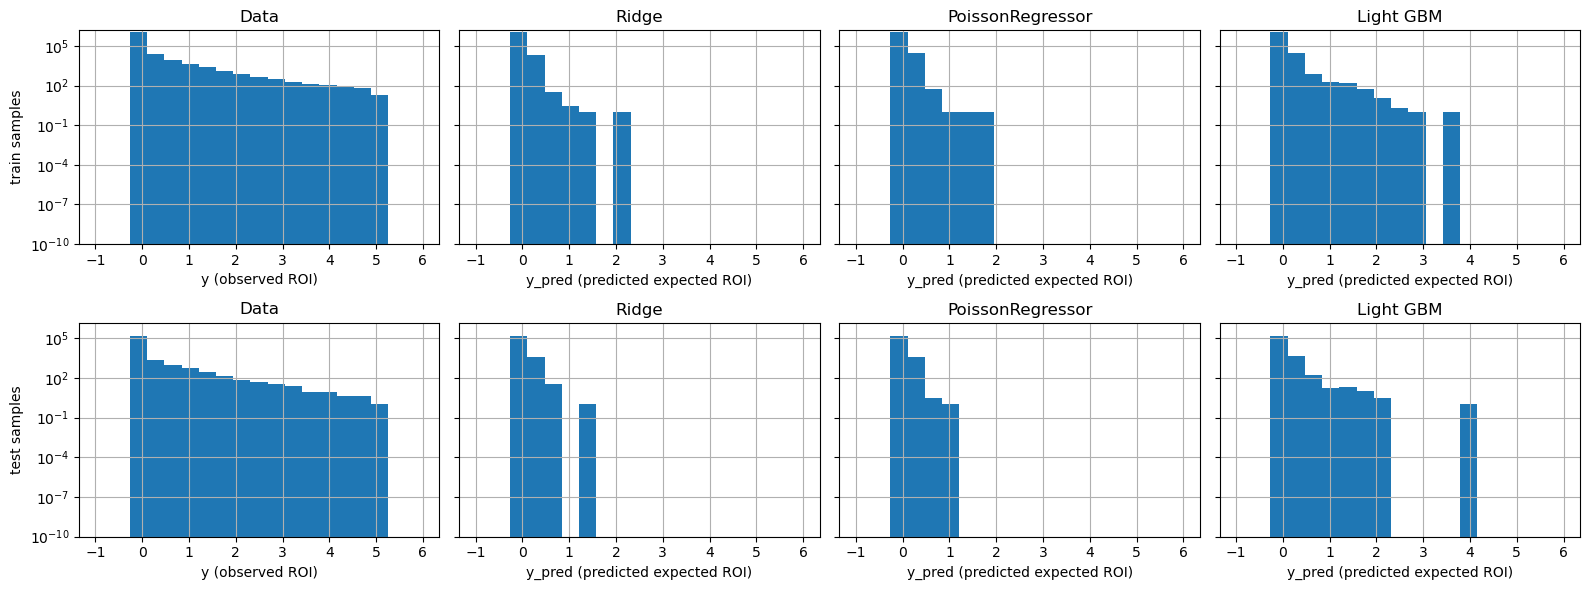

In [204]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharey=True)
fig.subplots_adjust(bottom=0.2)
n_bins = 20
bUpper = 6.
for row_idx, label, df in zip(range(2), ["train", "test"], [df_train, df_test]):
    df[args.targetColumn].hist(bins=np.linspace(-1, bUpper, n_bins), ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_yscale("log")
    axes[row_idx, 0].set_xlabel("y (observed ROI)")
    axes[row_idx, 0].set_ylim([1e-10, 1.5e6])
    axes[row_idx, 0].set_ylabel(label + " samples")

    for idx, model in enumerate([ridge_glm, poisson_glm, poisson_gbrt]):
        y_pred = model.predict(df)

        pd.Series(y_pred).hist(
            bins=np.linspace(-1, bUpper, n_bins), ax=axes[row_idx, idx + 1]
        )
        axes[row_idx, idx + 1].set(
            title= 'Light GBM' if re.search("Boost",model[-1].__class__.__name__,re.IGNORECASE)  else model[-1].__class__.__name__,
            yscale="log",
            xlabel="y_pred (predicted expected ROI)",
        )
plt.tight_layout()

Predicted number of claims by Ridge(alpha=0.0001): 3963.1
Predicted number of claims by PoissonRegressor(alpha=0.0001, solver='newton-cholesky'): 3756.6
Predicted number of claims by HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=128): 4005.5
Predicted number of claims by DummyRegressor(): 3338.5


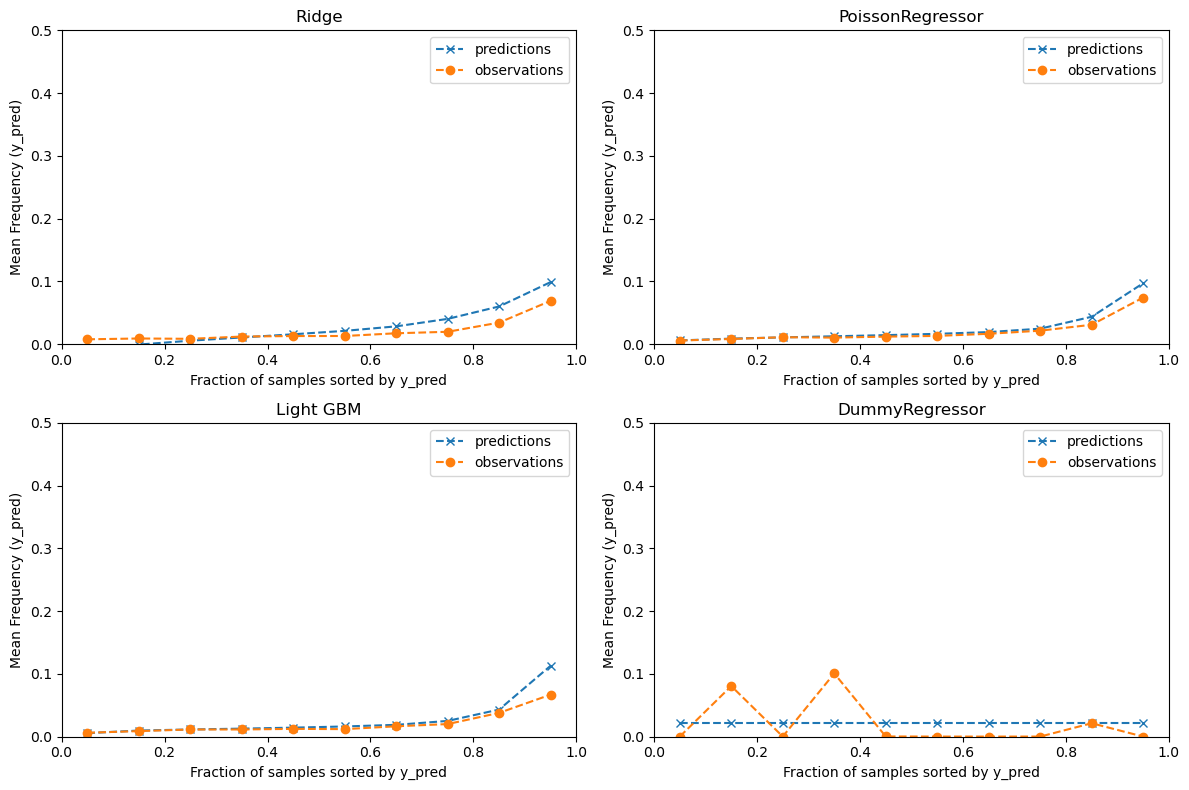

In [205]:
from sklearn.utils import gen_even_slices


def _mean_frequency_by_risk_group(y_true, y_pred, n_bins=100):
    """Compare predictions and observations for bins ordered by y_pred.

    We order the samples by ``y_pred`` and split it in bins.
    In each bin the observed mean is compared with the predicted mean.

    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,)
        Sample weights.
    n_bins: int
        Number of bins to use.

    Returns
    -------
    bin_centers: ndarray of shape (n_bins,)
        bin centers
    y_true_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    y_pred_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    """
    idx_sort = np.argsort(y_pred)
    bin_centers = np.arange(0, 1, 1 / n_bins) + 0.5 / n_bins
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        y_pred_bin[n] = np.average(y_pred[idx_sort][sl])
        y_true_bin[n] = np.average(y_true[idx_sort][sl])
    return bin_centers, y_true_bin, y_pred_bin

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.3)

for axi, model in zip(ax.ravel(), [ridge_glm, poisson_glm, poisson_gbrt, dummy]):
    y_pred = model.predict(df_test)
    y_true = df_test[args.targetColumn].values
    q, y_true_seg, y_pred_seg = _mean_frequency_by_risk_group(
        y_true, y_pred, n_bins=10
    )

    # Name of the model after the estimator used in the last step of the
    # pipeline.
    print(f"Predicted number of claims by {model[-1]}: {np.sum(y_pred):.1f}")

    axi.plot(q, y_pred_seg, marker="x", linestyle="--", label="predictions")
    axi.plot(q, y_true_seg, marker="o", linestyle="--", label="observations")
    axi.set_xlim(0, 1.0)
    axi.set_ylim(0, 0.5)
    axi.set(
        title='Light GBM' if re.search("Boost",model[-1].__class__.__name__,re.IGNORECASE)  else model[-1].__class__.__name__,
        xlabel="Fraction of samples sorted by y_pred",
        ylabel="Mean Frequency (y_pred)",
    )
    axi.legend()
plt.tight_layout()

In [ ]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)